# 80_PoissonRegressionDemo

#### Tiny investigation into Possion regression upon count data

      
+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Generate Data](#Generate-Data)


+ [Poisson Regression](#Poisson-Regression)


##### Package Requirements
```
$> less conda_env_pymc3_examples.yml

name: pymc3_examples
    channels:
      - defaults
    dependencies:
      - python=3.5
      - jupyter
      - numpy
      - scipy
      - matplotlib
      - pandas
      - seaborn
      - patsy  
      - pip
      - pip:
          - regex
          - Cython
          - pystan

$> conda env create --file conda_env_pymc3_examples.yml
$> source activate pymc3_examples
$> pip install --process-dependency-links git+https://github.com/pymc-devs/pymc3
```

# Setup

In [1]:
## Interactive magics
%matplotlib inline
%qtconsole --colors=linux

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')

import regex as re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pt
from scipy import optimize

# pymc3 libraries
import pymc3 as pm
import theano as thno
import theano.tensor as T 
import pystan

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = 12, 4
np.random.seed(0)

##### What versions are we running?

In [3]:
print('Python: {}'.format(sys.version))
print('Recursion limit {}'.format(sys.getrecursionlimit()))
print('theano: {}'.format(thno.__version__))
print('PyMC3: {}'.format(pm.__version__))
print('PyStan: {}'.format(pystan.__version__))

Python: 3.5.1 |Continuum Analytics, Inc.| (default, Dec  7 2015, 11:24:55) 
[GCC 4.2.1 (Apple Inc. build 5577)]
Recursion limit 10000
theano: 0.8.1
PyMC3: 3.0
PyStan: 2.9.0.0


## Local Functions

In [4]:
def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)     
    return ret_rvs

def plot_traces_pymc(trcs, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)
        
    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in 
                             pm.df_summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.df_summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022') 

## Generate Data

In [5]:
## sneezes get worse with booze whilst also no antihist
# note structured dataframe with noantihist as feature 
# so that alcohol == True & noantihist == True -> worst outcome

noalcohol_antihist = 1    # no booze, took an antihist
alcohol_antihist = 3      # booze, took an antihist
noalcohol_noantihist = 6  # no booze, no antihist
alcohol_noantihist = 11   # booze, no antihist

q = 1000
df = pd.DataFrame({
        'nsneeze': np.concatenate((np.random.poisson(noalcohol_antihist, q),
                                   np.random.poisson(alcohol_antihist, q),
                                   np.random.poisson(noalcohol_noantihist, q), 
                                   np.random.poisson(alcohol_noantihist, q))),
        'alcohol': np.concatenate((np.repeat(False, q),
                                   np.repeat(True, q),
                                   np.repeat(False, q),
                                   np.repeat(True, q))),
        'noantihist': np.concatenate((np.repeat(False, q),
                                      np.repeat(False, q),
                                      np.repeat(True, q),
                                      np.repeat(True, q)))})

In [6]:
df.groupby(['alcohol','noantihist']).mean().unstack()

nsneeze        
noantihist   False   True 
alcohol                   
False        1.018   5.866
True         2.938  10.888

##### Describe Dataset

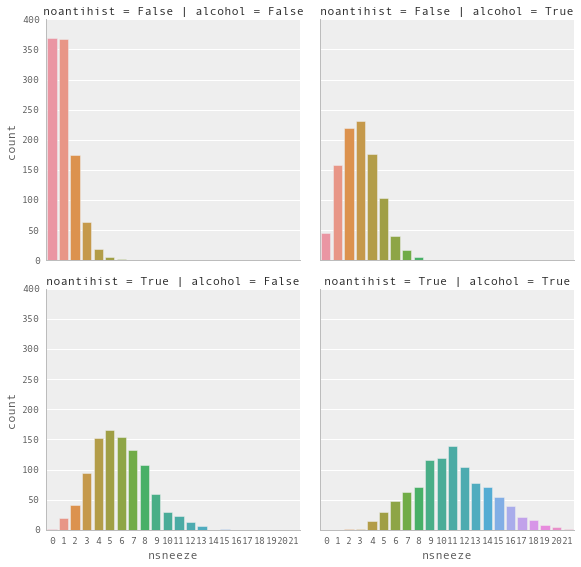

In [7]:
g = sns.factorplot(x='nsneeze', row='noantihist', col='alcohol', data=df,
               kind='count', size=4)

## Create design matrices

In [8]:
## fml = 'nsneeze ~ alcohol + antihist + alcohol:antihist'  # alt formualtion
fml = 'nsneeze ~ alcohol * noantihist'  # lazy formulation
(mx_en, mx_ex) = pt.dmatrices(fml, df, return_type='dataframe', NA_action='raise')
mx_ex.head()

,Intercept,alcohol[T.True],noantihist[T.True],alcohol[T.True]:noantihist[T.True]
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [9]:
mx_ex.tail()

,Intercept,alcohol[T.True],noantihist[T.True],alcohol[T.True]:noantihist[T.True]
3995,1.0,1.0,1.0,1.0
3996,1.0,1.0,1.0,1.0
3997,1.0,1.0,1.0,1.0
3998,1.0,1.0,1.0,1.0
3999,1.0,1.0,1.0,1.0


---

# Poisson Regression (PyMC3)

## Create Model (manual formulation)

In [10]:
with pm.Model() as mdl_fish:
    
    # define priors, use HalfCauchy to force positive
    b0 = pm.HalfCauchy('b0_intercept', beta=10)
    b1 = pm.HalfCauchy('b1_alcohol[T.True]', beta=10)
    b2 = pm.HalfCauchy('b2_noantihist[T.True]', beta=10)
    b3 = pm.HalfCauchy('b3_alcohol[T.True]:noantihist[T.True]', beta=10)
    
    # define linear model and link function
    mu = (b0 +
            b1 * mx_ex['alcohol[T.True]'] +
            b2 * mx_ex['noantihist[T.True]'] +
            b3 * mx_ex['alcohol[T.True]:noantihist[T.True]']) 

    ## Define Poisson likelihood 
    y = pm.Poisson('y', mu=mu, observed=mx_en['nsneeze'].values)
    

Applied log-transform to b0_intercept and added transformed b0_intercept_log to model.
Applied log-transform to b1_alcohol[T.True] and added transformed b1_alcohol[T.True]_log to model.
Applied log-transform to b2_noantihist[T.True] and added transformed b2_noantihist[T.True]_log to model.
Applied log-transform to b3_alcohol[T.True]:noantihist[T.True] and added transformed b3_alcohol[T.True]:noantihist[T.True]_log to model.


##### Alternative automatic formulation using `pmyc.glm`

In [11]:
## Not used since it adds log link function, I'm not sure if necessary
## when priors are HalfCauchy (and forced non-negative)

# with pm.Model() as mdl_fish:
    
#     pm.glm.glm(fml, df, family=pm.glm.families.Poisson())

## Sample Model

In [12]:
with mdl_fish:
    
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell)
    trc_fish = pm.sample(2000, start=start_MAP, njobs=2, step=pm.NUTS())

 [-----------------100%-----------------] 2000 of 2000 complete in 7.9 sec

## View diagnostics and outputs

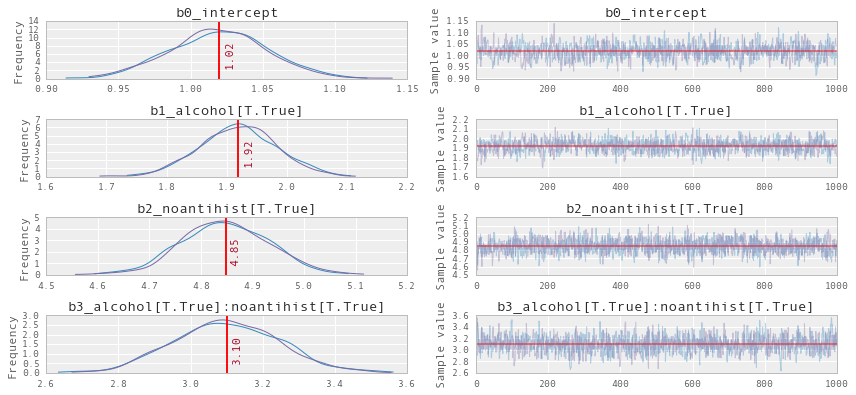

In [13]:
rvs_fish = [rv.name for rv in strip_derived_rvs(mdl_fish.unobserved_RVs)]
plot_traces_pymc(trc_fish[-1000:], varnames=rvs_fish)

In [14]:
pm.df_summary(trc_fish[-1000:], varnames=rvs_fish)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
b0_intercept,1.019651,0.033376,0.001291,0.956715,1.085859
b1_alcohol[T.True],1.918990,0.063751,0.002114,1.793545,2.041858
b2_noantihist[T.True],4.847619,0.083830,0.002172,4.687866,5.011654
b3_alcohol[T.True]:noantihist[T.True],3.099672,0.144668,0.004250,2.826607,3.377783


**Observe**

+ Model converges quickly and traceplots looks pretty well mixed

+ We've found the contributions from each feature as per the means used in the data generation

    b0_intercept = 1.02           
        # (noalcohol_antihist = 1)
    b1_alcohol = 1.92            
        # (noalcohol_antihist + alcohol_antihist = 1 + 2 = 3)
    b2_noantihist[T.True] = 4.85    
        # (noalcohol_antihist + noalcohol_noantihist = 1 + 5 = 6)
    b3_alcohol[T.True]:noantihist[T.True] = 3.10       
        # noalcohol_antihist + alcohol_antihist + \
          noalcohol_noantihist + alcohol_noantihist = 1 + 2 + 5 + 3 = 11

   
+ In this case, all coeffs are far from 0, so they do have an appreciable effect on the sneeze rate, so:

    + 'Baseline' of no alcohol, plus antihist gives a sneeze poisson mean of 1
    + Add alcohol, increases poisson mean by 2
    + No alcohol, but no antihist increases poisson mean by 5
    + Add alcohol, and no antihist has an interaction effect and increases poisson mean by a further 3


**NOTES:**

+ I think I have my logic correct
+ This is all wild hand-waving YMMV

---

# Additional Poisson Regression using PyStan for comparison

## Create Model

##### Define Input Dir

In [15]:
mdl_fish_stan_dict = {}
mdl_fish_stan_dict['N'] = mx_ex.shape[0]
mdl_fish_stan_dict['K'] = mx_ex.shape[1]
mdl_fish_stan_dict['X'] = mx_ex.values
mdl_fish_stan_dict['y'] = mx_en['nsneeze'].values.astype(np.int64)

##### Define Model

In [16]:
mdl_fish_stan_spec = """

    /* Spec for poisson regression model */

    data {                                 
        int<lower=0> N;                     // count of observations
        int<lower=0> K;                     // count of exog features
        matrix[N, K] X;                     // exog features
        int<lower=0> y[N];                  // endog feature (force int)
    }
    parameters {
        vector[K] beta;                     // exog coeffs
    }
    transformed parameters {}
    model {
        y ~ poisson(X * beta);                 // poisson likelihood
    }
    generated quantities {}
    """

## Compile and sample

In [17]:
mdl_fish_stan_fit = pystan.stan(
        model_code  = mdl_fish_stan_spec,
        data        = mdl_fish_stan_dict,
        model_name  = 'mdl_fish_stan',
        iter        = 1000,
        warmup      = 750, 
        chains      = 4, 
        n_jobs      = 2, 
        verbose     = False)

## View results

##### View traceplots

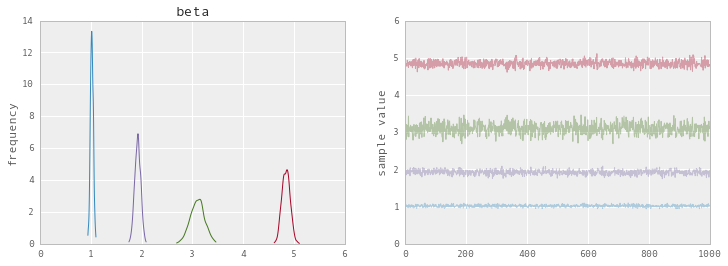

In [18]:
mdl_fish_stan_fit.plot(pars='beta')
plt.show()

##### View summary

In [19]:
print(mdl_fish_stan_fit)

Inference for Stan model: mdl_fish_stan_b2bd3f19e6e59e822bf25c1b3503000c.
4 chains, each with iter=1000; warmup=750; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]   1.02  1.9e-3   0.03   0.96    1.0   1.02   1.04   1.08    236   1.01
beta[1]   1.92  3.9e-3   0.06   1.81   1.88   1.92   1.96   2.04    220   1.01
beta[2]   4.85  5.0e-3   0.08    4.7   4.79   4.85    4.9    5.0    249    1.0
beta[3]    3.1  8.9e-3   0.14   2.82    3.0    3.1   3.19   3.38    246    1.0
lp__     1.9e4    0.09    1.3  1.9e4  1.9e4  1.9e4  1.9e4  1.9e4    188   1.02

Samples were drawn using NUTS(diag_e) at Tue Apr 26 16:55:10 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


##### Extract results and transform

In [20]:
samples = mdl_fish_stan_fit.extract(permuted=True)  # return a dict of arrays
dftrc_fish_stan = pd.DataFrame(samples['beta'],columns=mx_ex.columns.tolist())

In [21]:
dftrc_fish_stan.describe(percentiles=[.025,.975])

,Intercept,alcohol[T.True],noantihist[T.True],alcohol[T.True]:noantihist[T.True]
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.018392,1.922233,4.845889,3.099286
std,0.028734,0.058474,0.079310,0.139154
min,0.939970,1.749012,4.612955,2.688806
2.5%,0.963369,1.808085,4.701612,2.823282
50%,1.017325,1.923765,4.847720,3.099974
97.5%,1.075700,2.035452,4.998230,3.374568
max,1.098630,2.088434,5.110634,3.464361


**Observe:**

+ Cool, roughly the same results as above for PyMC3

---
**Applied AI Ltd &copy; 2016**  
<a href='http://www.applied.ai'>applied.ai</a>